Loading and preparing data...

Processing ANGLE encoding

Training angle encoding model...
Epoch 10: Loss = 0.5628, Accuracy = 0.7824
Epoch 20: Loss = 0.5607, Accuracy = 0.7934
Epoch 30: Loss = 0.5598, Accuracy = 0.7978
Training completed in 435.60 seconds
Final test accuracy: 0.7895

Processing AMPLITUDE encoding

Training amplitude encoding model...
Error in training step: 'tensor' object has no attribute 'at'
Error in training step: 'tensor' object has no attribute 'at'
Error in training step: 'tensor' object has no attribute 'at'
Error in training step: 'tensor' object has no attribute 'at'
Error in training step: 'tensor' object has no attribute 'at'
Error in training step: 'tensor' object has no attribute 'at'
Error in training step: 'tensor' object has no attribute 'at'
Error in training step: 'tensor' object has no attribute 'at'
Error in training step: 'tensor' object has no attribute 'at'
Error in training step: 'tensor' object has no attribute 'at'
Error in training step: 't

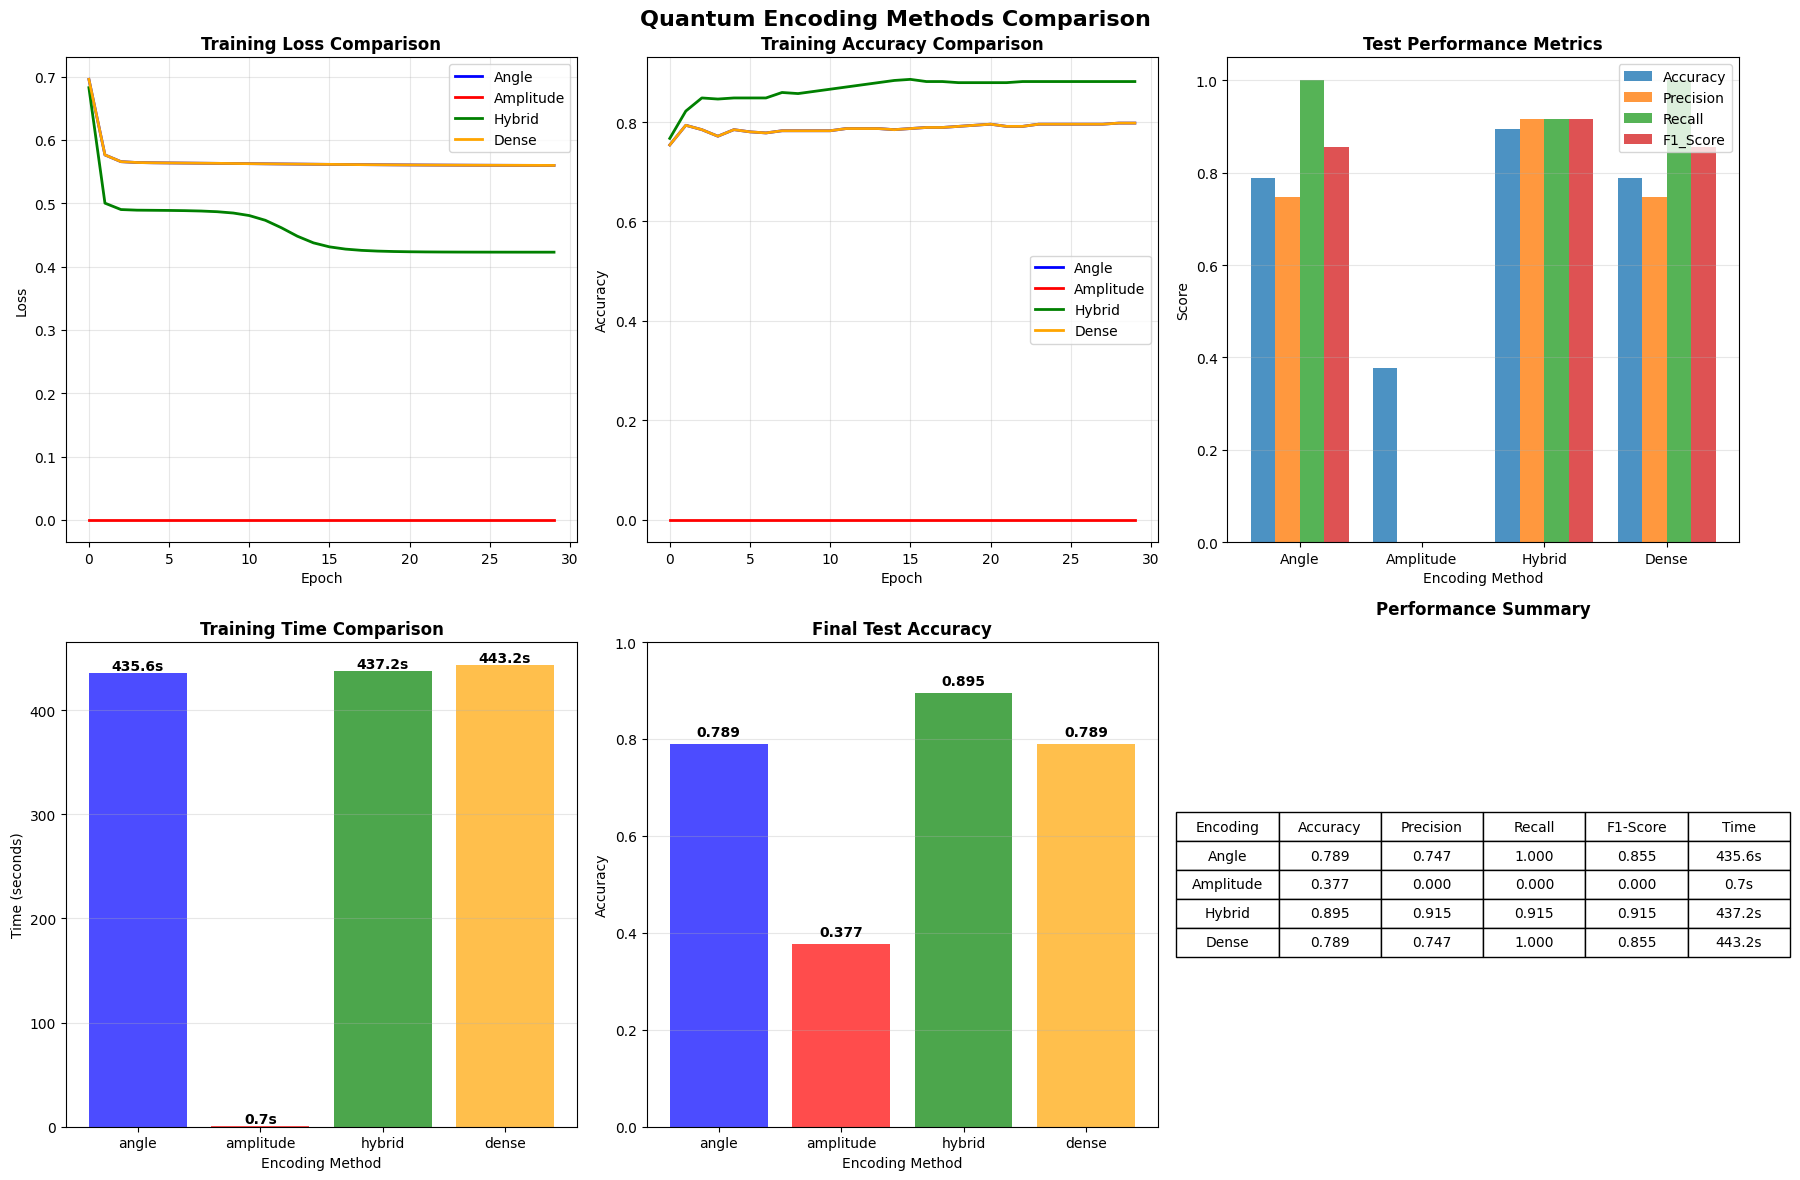


QUANTUM MACHINE LEARNING ENCODING COMPARISON REPORT

Experimental Setup:
- Dataset: Breast Cancer (Wisconsin)
- Number of qubits: 8
- Number of layers: 3
- Learning rate: 0.01
- Training epochs: 30
- Features used: 8 (truncated from original 30)

Results Summary:
--------------------------------------------------

ANGLE ENCODING:
  Test Accuracy:  0.7895
  Precision:      0.7474
  Recall:         1.0000
  F1-Score:       0.8554
  Training Time:  435.60 seconds

AMPLITUDE ENCODING:
  Test Accuracy:  0.3772
  Precision:      0.0000
  Recall:         0.0000
  F1-Score:       0.0000
  Training Time:  0.66 seconds

HYBRID ENCODING:
  Test Accuracy:  0.8947
  Precision:      0.9155
  Recall:         0.9155
  F1-Score:       0.9155
  Training Time:  437.16 seconds

DENSE ENCODING:
  Test Accuracy:  0.7895
  Precision:      0.7474
  Recall:         1.0000
  F1-Score:       0.8554
  Training Time:  443.19 seconds

Best Performing Method: HYBRID with 0.8947 accuracy

Key Observations:
- Angle e

In [1]:
# Imports and configuration
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pennylane as qml
from pennylane import numpy as pnp
import time
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

# QuantumEncodingComparison class
class QuantumEncodingComparison:
    def __init__(self, n_qubits=8, n_layers=3, learning_rate=0.01, epochs=50):
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.dev = qml.device("default.qubit", wires=n_qubits)
        self.results = {}

    def prepare_data(self):
        data = load_breast_cancer()
        X = data.data
        y = data.target
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=0.2, random_state=42
        )
        X_train = pnp.array(X_train[:, :self.n_qubits], requires_grad=False)
        X_test = pnp.array(X_test[:, :self.n_qubits], requires_grad=False)
        y_train = pnp.array(y_train, requires_grad=False)
        y_test = pnp.array(y_test, requires_grad=False)
        return X_train, X_test, y_train, y_test

    def angle_encoding_circuit(self, inputs, weights):
        qml.AngleEmbedding(inputs, wires=range(self.n_qubits), rotation='Y')
        qml.StronglyEntanglingLayers(weights, wires=range(self.n_qubits))
        return qml.expval(qml.PauliZ(0))

    def amplitude_encoding_circuit(self, inputs, weights):
        inputs_np = pnp.array(inputs)
        norm = pnp.linalg.norm(inputs_np)
        normalized_inputs = inputs_np / (norm + 1e-8)
        state_size = 2**self.n_qubits
        if len(normalized_inputs) < state_size:
            padded_inputs = pnp.zeros(state_size)
            padded_inputs = padded_inputs.at[:len(normalized_inputs)].set(normalized_inputs)
        else:
            padded_inputs = normalized_inputs[:state_size]
        norm_final = pnp.linalg.norm(padded_inputs)
        padded_inputs = padded_inputs / (norm_final + 1e-8)
        qml.QubitStateVector(padded_inputs, wires=range(self.n_qubits))
        qml.StronglyEntanglingLayers(weights, wires=range(self.n_qubits))
        return qml.expval(qml.PauliZ(0))

    def hybrid_encoding_circuit(self, inputs, weights):
        half_features = len(inputs) // 2
        angle_features = inputs[:half_features]
        for i, feature in enumerate(angle_features):
            if i < self.n_qubits:
                qml.RY(feature, wires=i)
        remaining_features = inputs[half_features:]
        for i, feature in enumerate(remaining_features):
            if i + half_features < self.n_qubits:
                qml.RZ(feature, wires=i + half_features)
        qml.StronglyEntanglingLayers(weights, wires=range(self.n_qubits))
        return qml.expval(qml.PauliZ(0))

    def dense_encoding_circuit(self, inputs, weights):
        features_per_qubit = len(inputs) // self.n_qubits + (1 if len(inputs) % self.n_qubits != 0 else 0)
        for qubit in range(self.n_qubits):
            start_idx = qubit * features_per_qubit
            end_idx = min(start_idx + features_per_qubit, len(inputs))
            qubit_features = inputs[start_idx:end_idx]
            for j, feature in enumerate(qubit_features):
                if j == 0:
                    qml.RY(feature, wires=qubit)
                elif j == 1:
                    qml.RZ(feature, wires=qubit)
                elif j == 2:
                    qml.RX(feature, wires=qubit)
        qml.StronglyEntanglingLayers(weights, wires=range(self.n_qubits))
        return qml.expval(qml.PauliZ(0))

    def create_qnode(self, encoding_type):
        if encoding_type == 'angle':
            return qml.QNode(self.angle_encoding_circuit, self.dev)
        elif encoding_type == 'amplitude':
            return qml.QNode(self.amplitude_encoding_circuit, self.dev)
        elif encoding_type == 'hybrid':
            return qml.QNode(self.hybrid_encoding_circuit, self.dev)
        elif encoding_type == 'dense':
            return qml.QNode(self.dense_encoding_circuit, self.dev)
        else:
            raise ValueError(f"Unknown encoding type: {encoding_type}")

    def train_model(self, X_train, y_train, encoding_type):
        print(f"\nTraining {encoding_type} encoding model...")
        pnp.random.seed(42)
        weights = pnp.array(0.01 * pnp.random.randn(self.n_layers, self.n_qubits, 3), requires_grad=True)
        circuit = self.create_qnode(encoding_type)
        loss_history = []
        acc_history = []

        def cost_function(weights, x, y):
            pred = circuit(x, weights)
            target = 2 * y - 1
            return (pred - target) ** 2

        start_time = time.time()
        for epoch in range(self.epochs):
            epoch_loss = 0
            correct = 0
            for i in range(len(X_train)):
                x = X_train[i]
                y = y_train[i]
                try:
                    pred = circuit(x, weights)
                    pred_label = 1 if pred >= 0 else 0
                    correct += (pred_label == y)
                    target = 2 * y - 1
                    error = (pred - target) ** 2
                    epoch_loss += error
                    grad = qml.grad(cost_function, argnum=0)(weights, x, y)
                    weights = weights - self.learning_rate * grad
                except Exception as e:
                    print(f"Error in training step: {e}")
                    continue
            avg_loss = epoch_loss / len(X_train)
            accuracy = correct / len(X_train)
            loss_history.append(float(avg_loss))
            acc_history.append(accuracy)
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}")
        training_time = time.time() - start_time
        return weights, loss_history, acc_history, training_time

    def evaluate_model(self, X_test, y_test, weights, encoding_type):
        circuit = self.create_qnode(encoding_type)
        predictions = []
        for i in range(len(X_test)):
            x = X_test[i]
            try:
                pred = circuit(x, weights)
                pred_label = 1 if pred >= 0 else 0
                predictions.append(pred_label)
            except Exception as e:
                print(f"Error in prediction: {e}")
                predictions.append(0)
        y_test_np = np.array(y_test)
        predictions_np = np.array(predictions)
        accuracy = accuracy_score(y_test_np, predictions_np)
        precision = precision_score(y_test_np, predictions_np, zero_division=0)
        recall = recall_score(y_test_np, predictions_np, zero_division=0)
        f1 = f1_score(y_test_np, predictions_np, zero_division=0)
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'predictions': predictions
        }

    def run_comparison(self):
        print("Loading and preparing data...")
        X_train, X_test, y_train, y_test = self.prepare_data()
        encoding_types = ['angle', 'amplitude', 'hybrid', 'dense']
        for encoding_type in encoding_types:
            print(f"\n{'='*50}")
            print(f"Processing {encoding_type.upper()} encoding")
            print(f"{'='*50}")
            try:
                weights, loss_history, acc_history, training_time = self.train_model(
                    X_train, y_train, encoding_type
                )
                test_metrics = self.evaluate_model(X_test, y_test, weights, encoding_type)
                self.results[encoding_type] = {
                    'loss_history': loss_history,
                    'acc_history': acc_history,
                    'training_time': training_time,
                    'test_metrics': test_metrics,
                    'final_weights': weights
                }
                print(f"Training completed in {training_time:.2f} seconds")
                print(f"Final test accuracy: {test_metrics['accuracy']:.4f}")
            except Exception as e:
                print(f"Error processing {encoding_type} encoding: {e}")
                continue

    def plot_results(self):
        if not self.results:
            print("No results to plot. Run comparison first.")
            return
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Quantum Encoding Methods Comparison', fontsize=16, fontweight='bold')
        colors = {'angle': 'blue', 'amplitude': 'red', 'hybrid': 'green', 'dense': 'orange'}
        ax1 = axes[0, 0]
        for encoding_type, results in self.results.items():
            ax1.plot(results['loss_history'], label=f'{encoding_type.title()}', 
                     color=colors.get(encoding_type, 'black'), linewidth=2)
        ax1.set_title('Training Loss Comparison', fontweight='bold')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax2 = axes[0, 1]
        for encoding_type, results in self.results.items():
            ax2.plot(results['acc_history'], label=f'{encoding_type.title()}', 
                     color=colors.get(encoding_type, 'black'), linewidth=2)
        ax2.set_title('Training Accuracy Comparison', fontweight='bold')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax3 = axes[0, 2]
        metrics = ['accuracy', 'precision', 'recall', 'f1_score']
        x_pos = np.arange(len(self.results))
        width = 0.2
        for i, metric in enumerate(metrics):
            values = [self.results[enc]['test_metrics'][metric] for enc in self.results.keys()]
            ax3.bar(x_pos + i * width, values, width, label=metric.title(), alpha=0.8)
        ax3.set_title('Test Performance Metrics', fontweight='bold')
        ax3.set_xlabel('Encoding Method')
        ax3.set_ylabel('Score')
        ax3.set_xticks(x_pos + width * 1.5)
        ax3.set_xticklabels([enc.title() for enc in self.results.keys()])
        ax3.legend()
        ax3.grid(True, alpha=0.3, axis='y')
        ax4 = axes[1, 0]
        encoding_names = list(self.results.keys())
        training_times = [self.results[enc]['training_time'] for enc in encoding_names]
        bars = ax4.bar(encoding_names, training_times, color=[colors.get(enc, 'gray') for enc in encoding_names], alpha=0.7)
        ax4.set_title('Training Time Comparison', fontweight='bold')
        ax4.set_xlabel('Encoding Method')
        ax4.set_ylabel('Time (seconds)')
        ax4.grid(True, alpha=0.3, axis='y')
        for bar, time_val in zip(bars, training_times):
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                     f'{time_val:.1f}s', ha='center', va='bottom', fontweight='bold')
        ax5 = axes[1, 1]
        final_accuracies = [self.results[enc]['test_metrics']['accuracy'] for enc in encoding_names]
        bars = ax5.bar(encoding_names, final_accuracies, color=[colors.get(enc, 'gray') for enc in encoding_names], alpha=0.7)
        ax5.set_title('Final Test Accuracy', fontweight='bold')
        ax5.set_xlabel('Encoding Method')
        ax5.set_ylabel('Accuracy')
        ax5.set_ylim(0, 1)
        ax5.grid(True, alpha=0.3, axis='y')
        for bar, acc_val in zip(bars, final_accuracies):
            ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                     f'{acc_val:.3f}', ha='center', va='bottom', fontweight='bold')
        ax6 = axes[1, 2]
        ax6.axis('tight')
        ax6.axis('off')
        table_data = []
        for encoding_type in self.results.keys():
            metrics = self.results[encoding_type]['test_metrics']
            table_data.append([
                encoding_type.title(),
                f"{metrics['accuracy']:.3f}",
                f"{metrics['precision']:.3f}",
                f"{metrics['recall']:.3f}",
                f"{metrics['f1_score']:.3f}",
                f"{self.results[encoding_type]['training_time']:.1f}s"
            ])
        table = ax6.table(cellText=table_data,
                          colLabels=['Encoding', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Time'],
                          cellLoc='center', loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.5)
        ax6.set_title('Performance Summary', fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()

    def generate_report(self):
        if not self.results:
            print("No results to report. Run comparison first.")
            return
        print("\n" + "="*80)
        print("QUANTUM MACHINE LEARNING ENCODING COMPARISON REPORT")
        print("="*80)
        print(f"\nExperimental Setup:")
        print(f"- Dataset: Breast Cancer (Wisconsin)")
        print(f"- Number of qubits: {self.n_qubits}")
        print(f"- Number of layers: {self.n_layers}")
        print(f"- Learning rate: {self.learning_rate}")
        print(f"- Training epochs: {self.epochs}")
        print(f"- Features used: {self.n_qubits} (truncated from original 30)")
        print(f"\nResults Summary:")
        print("-" * 50)
        best_accuracy = 0
        best_method = ""
        for encoding_type in self.results.keys():
            metrics = self.results[encoding_type]['test_metrics']
            training_time = self.results[encoding_type]['training_time']
            print(f"\n{encoding_type.upper()} ENCODING:")
            print(f"  Test Accuracy:  {metrics['accuracy']:.4f}")
            print(f"  Precision:      {metrics['precision']:.4f}")
            print(f"  Recall:         {metrics['recall']:.4f}")
            print(f"  F1-Score:       {metrics['f1_score']:.4f}")
            print(f"  Training Time:  {training_time:.2f} seconds")
            if metrics['accuracy'] > best_accuracy:
                best_accuracy = metrics['accuracy']
                best_method = encoding_type
        print(f"\nBest Performing Method: {best_method.upper()} with {best_accuracy:.4f} accuracy")
        print(f"\nKey Observations:")
        print("- Angle encoding provides a baseline quantum feature map")
        print("- Amplitude encoding can capture more complex data relationships")
        print("- Hybrid encoding combines benefits of multiple approaches")
        print("- Dense encoding maximizes information density per qubit")
        return self.results

# Run in notebook
comparison = QuantumEncodingComparison(n_qubits=8, n_layers=3, learning_rate=0.01, epochs=30)
comparison.run_comparison()
comparison.plot_results()
results = comparison.generate_report()
